# Overview

This notebook includes analysis of US Census and linkNYC (public wifi) location. The objective is to assess if linkNYC is providing useful service and filling in a need.

### Data Sources
- Census: National survey data
- PUMA: Public Use Microdata Area
- American Fact Finder: percentage of houses with broadband internet access
- LinkNYC: locations of linkNYC stations

### Tools
- Geopandas: spatial analysis using Python
- API: data access through API request

---

## 1) Get and Visualize PUMA Data

In [161]:
# Python 2 AND 3 Compatibility Importing

try:
    # Python 3
    from urllib.parse import urlparse, urlencode
    from urllib.request import urlopen, Request
    from urllib.error import HTTPError
    from urllib.request import urlretrieve
except ImportError:
    # Python 2
    from urlparse import urlparse
    from urllib import urlencode
    from urllib import urlretrieve
    from urllib2 import urlopen, Request, HTTPError

import requests
import pandas as pd
import geopandas as gpd 
import matplotlib.pylab as plt
import gzip
import glob
import os.path
import sys
import json
from fiona.crs import from_epsg
import io
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [162]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

try:
    urlretrieve(url, "file.zip")
    if os.path.isfile("geo_export_9ba1f910-5f02-480a-846e-ca91f6764a02.shp"):
        print("Files exist. Pass.")
    else:
        !unzip file.zip
except:
    urlretrieve(url, "file.zip")
    if os.path.isfile("geo_export_9ba1f910-5f02-480a-846e-ca91f6764a02.shp"):
        print("Files exist. Pass.")
    else:
        !unzip file.zip

Files exist. Pass.


In [163]:
# Read PUMA shape file
puma_df = gpd.GeoDataFrame.from_file("geo_export_9ba1f910-5f02-480a-846e-ca91f6764a02.shp")

In [164]:
puma_df.crs

{'init': 'epsg:4326'}

In [165]:
puma_df.head(10)

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...
5,3706,51799.404764,4.388687e+07,POLYGON ((-73.91328437051338 40.85961860183316...
6,3707,37347.926177,4.228113e+07,POLYGON ((-73.91328437051338 40.85961860183316...
7,3708,34853.551314,5.589653e+07,"POLYGON ((-73.92478318783078 40.8447526648105,..."
8,3709,73289.990781,1.241170e+08,(POLYGON ((-73.83667856364177 40.8175887629137...
9,3710,91116.970113,1.377977e+08,(POLYGON ((-73.89680883223774 40.7958084451597...


In [166]:
# Install choroplethNYC package if needed
# Import choroplethNYC package

try:
    if os.path.exists("./choroplethNYC"):
        print("Files already exist. Skip Download.")
        cwd = os.getcwd()
        sys.path.append(cwd + "/choroplethNYC")
        import choroplethNYC as cp
        print("choroplethNYC import complete")
    else:
        !git clone https://github.com/fedhere/choroplethNYC.git
        cwd = os.getcwd()
        sys.path.append(cwd + "/choroplethNYC")
        import choroplethNYC as cp
        print("choroplethNYC import complete")
except Exception as e:
    print(e)
    print("exit...")

Files already exist. Skip Download.
choroplethNYC import complete


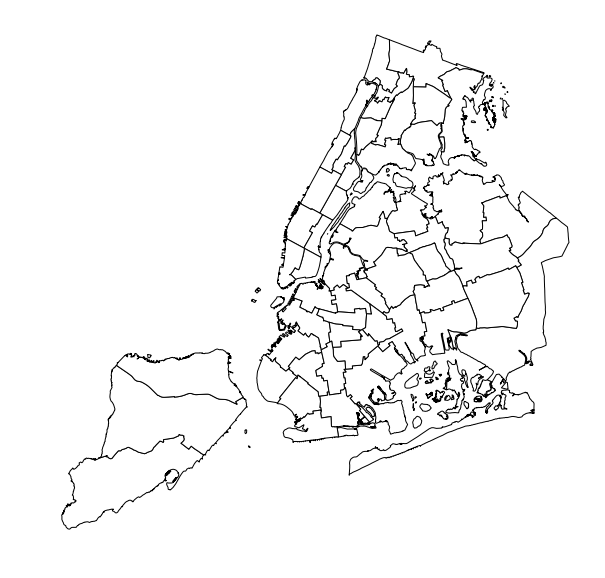

In [220]:
# plot PUMA data using ChoroplethNYC package
f = cp.choroplethNYC(puma_df, column=None, color="white", edgecolor="black");

## Figure 1
This is a spatial graph of PUMA data of NYC. PUMAs are statistical geographic areas defined for the dissemination of Public Use Microdata Sample. PUMAs have a minimum population of 100,000, are aggregated from census tracts, and approximate Community Districts (CDs), or combinations of CDs. This geography is also used for disseminating American Community Survey (ACS) estmates.

---

## 2) Get Broadband Usage Data from American Fact Finder

- Use API
- Download data from ACS website (pre-download and stored on Dropbox)

In [168]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request("GET", url)
aff1y = json.loads(resp.text)

In [169]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [170]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of 

In [171]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [172]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [173]:
# getting the broadband access number of households
keyNBB = 'B28002_004E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [174]:
#getting the first row of the table: the total number of households
keyNBB = 'B28002_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [175]:
# Create a feature for percentage of households with broadband access

pumaBB = pumaBB.merge(pumaPP, how = "left", left_on = "NAME", right_on = "NAME")

In [176]:
pumaBB.head()

,B28002_004E,NAME,state_x,public use microdata area_x,Unnamed: 4_x,B28002_001E,state_y,public use microdata area_y,Unnamed: 4_y
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,36,402,NaN


In [177]:
pumaBB['pcBB'] = pumaBB['B28002_004E']*100/pumaBB['B28002_001E']
pumaBB = pumaBB[['B28002_004E', 'B28002_001E', 'NAME', 'public use microdata area_x','pcBB']]
pumaBB.columns = ['household_with_BB', 'total_household', 'PUMA_Name', 'PUMA_cd', 'pcBB']
pumaBB.head()

,household_with_BB,total_household,PUMA_Name,PUMA_cd,pcBB
0,32607,40479,"St. Lawrence County PUMA, New York",100,80.552879
1,50811,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",200,75.733321
2,41210,51614,"Warren & Washington Counties PUMA, New York",300,79.842678
3,36075,44300,Herkimer (North & Central) & Oneida (Outer) Co...,401,81.433409
4,47786,61146,Oneida County (Central)--Greater Utica & Rome ...,402,78.150656


---

### Download Broadband Percentage Stats from a ACS File

In [178]:
# download Broadband survey data from Dropbox if it's not already exist

url = 'https://www.dropbox.com/s/uxu2ownozbdy1xf/ACS_16_1YR_GCT2801.ST50.zip?dl=1'

if os.path.isfile("ACS_16_1YR_GCT2801.ST50_with_ann.csv"):
    print("File already exist. Pass.")
else:
    urlretrieve(url, "ACS_16_1YR_GCT2801.zip")
    !unzip ACS_16_1YR_GCT2801.zip

File already exist. Pass.


In [179]:
# read the broadband data into a dataframe

bbpc = pd.read_csv("ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GEO.display-label","GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.drop(0, inplace = True)
bbpc.head()

,GEO.display-label,GCT_STUB.target-geo-id2,HC01,HC02
1,Alabama,01,74.7,0.5
2,Alabama,0100100,70.9,2.5
3,Alabama,0100200,80.5,2.7
4,Alabama,0100301,87.0,2.8
5,Alabama,0100302,81.9,2.9


In [180]:
bbpc_nyc = bbpc[(bbpc['GEO.display-label'] == "New York")]
bbpc_nyc["GCT_STUB.target-geo-id2"] = bbpc_nyc["GCT_STUB.target-geo-id2"].astype(int)
bbpc_nyc["PUMA_id"] = bbpc_nyc["GCT_STUB.target-geo-id2"] - 3600000
bbpc_nyc.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,GEO.display-label,GCT_STUB.target-geo-id2,HC01,HC02,PUMA_id
1412,New York,36,81.7,0.2,-3599964
1413,New York,3600100,80.6,2.6,100
1414,New York,3600200,75.7,2.2,200
1415,New York,3600300,79.8,2.6,300
1416,New York,3600401,81.4,2.4,401


In [181]:
# Compare Percentage of Households with Broadband from API and Direct Download

diff_ = pumaBB.merge(bbpc_nyc, right_on="PUMA_id", 
                     left_on="PUMA_cd")[["pcBB", "HC01"]]
diff_["HC01"] = diff_["HC01"].astype(float)
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"])

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


--- 

## 3) Plot a Choropleth of NYC Broadband Access


In [182]:
puma_df['puma'] = puma_df['puma'].astype(int)
puma_df = puma_df.merge(bbpc_nyc, how = "left", left_on = "puma", right_on = "PUMA_id")

In [183]:
puma_df.sample(10, random_state= 123)

,puma,shape_leng,shape_area,geometry,GEO.display-label,GCT_STUB.target-geo-id2,HC01,HC02,PUMA_id
49,4109,95285.371730,1.669799e+08,POLYGON ((-73.90175373483066 40.76077547495726...,New York,3604109,85.1,2.4,4109
40,4018,76143.432445,9.599590e+07,POLYGON ((-73.97148350854722 40.59717158495798...,New York,3604018,79.3,2.4,4018
11,3802,37925.007815,4.689674e+07,POLYGON ((-73.97110765852325 40.80579013917414...,New York,3603802,80.2,3.9,3802
27,4005,95474.334642,1.145092e+08,POLYGON ((-73.96969317549156 40.67536085493595...,New York,3604005,89.4,2.4,4005
26,4004,73148.014179,8.663728e+07,POLYGON ((-73.97232032073779 40.70908288330405...,New York,3604004,85.5,1.9,4004
23,4001,74076.370458,1.149292e+08,POLYGON ((-73.95439555417087 40.73911477252251...,New York,3604001,70.6,2.8,4001
50,4110,71251.084697,2.050472e+08,POLYGON ((-73.89783236941891 40.73516035418231...,New York,3604110,82.6,2.2,4110
51,4111,56323.013991,1.326035e+08,POLYGON ((-73.82009462642849 40.70957598523835...,New York,3604111,83.8,2.3,4111
13,3804,62599.502332,6.461210e+07,(POLYGON ((-73.92133752419279 40.8008521075021...,New York,3603804,75.2,3.5,3804
21,3902,153476.166311,6.760397e+08,"POLYGON ((-74.1471964665355 40.60856292924328,...",New York,3603902,80.1,3.4,3902


In [184]:
puma_df.shape

(55, 9)

In [185]:
# Check if there is any NULL values
puma_df.isnull().sum()

puma                       0
shape_leng                 0
shape_area                 0
geometry                   0
GEO.display-label          0
GCT_STUB.target-geo-id2    0
HC01                       0
HC02                       0
PUMA_id                    0
dtype: int64

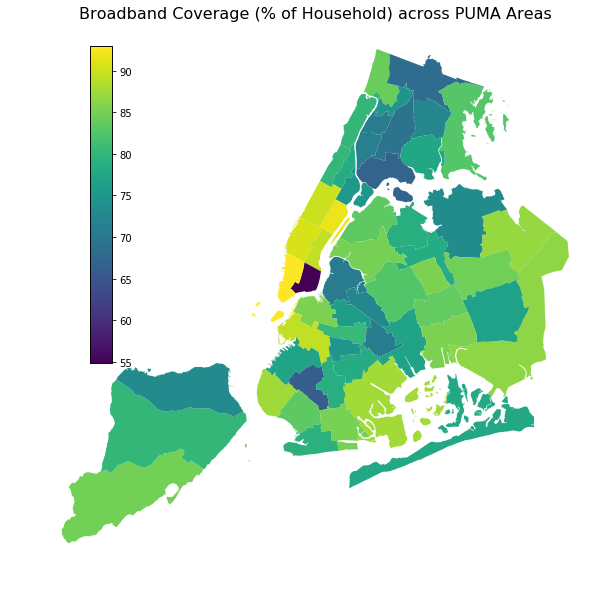

In [221]:
f, ax, cb = cp.choroplethNYC(puma_df, column="HC01", kind = "continuous", cmap = "viridis");
ax.set_title("Broadband Coverage (% of Household) across PUMA Areas", size = 16);

## Figure 2

This is a choropleth of broadband access across each PUMA area. Light green indicates common access to broadband internet at home. Dark blue indicates limited access. The area with the poorest access is lower east Manhattan (only about 55%). This may due to the high density of lower income housing in the area. 

--- 

## 4) Process and Plot LinkNYC Locations

In [241]:
url = "https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv"

linkNYC = pd.read_csv(url)
del linkNYC['Unnamed: 0']
linkNYC['date_link_'] = pd.to_datetime(linkNYC['date_link_'], infer_datetime_format= True)

In [242]:
linkNYC.sample(10)

,link_site,longitude,date_link_,latitude
808,qu-01-130522,-73.924856,2017-05-12,40.761646
20,bk-06-126392,-73.994526,2017-08-10,40.685390
1052,mn-10-137182,-73.942649,2016-10-29,40.816446
1333,bk-01-145858,-73.946853,2017-06-30,40.719511
1142,mn-04-123661,-73.994537,2017-11-04,40.745448
306,mn-08-128748,-73.958697,2016-03-05,40.772144
198,mn-04-108137,-73.995525,2016-04-19,40.749827
985,mn-09-135244,-73.945775,2017-10-19,40.827925
1236,qu-04-145768,-73.871648,2017-03-04,40.733579
963,mn-03-137173,-73.989083,2016-11-17,40.720486


In [243]:
linkNYC.dtypes

link_site             object
longitude            float64
date_link_    datetime64[ns]
latitude             float64
dtype: object

In [190]:
# Create lat/long column

def lonlat(x1, x2):
    
    return "(" + str(x1) + ", " + str(x2) + ")"

linkNYC['lonlat'] = linkNYC[['longitude', 'latitude']].apply(lambda row: lonlat(row['longitude'], row['latitude']),
                                                            axis = 1)

In [244]:
from shapely.geometry import Point

linkNYC['geometry'] = linkNYC.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis = 1)
geoLinkNYC = gpd.GeoDataFrame(linkNYC, geometry = 'geometry', crs = puma_df.crs)

In [245]:
geoLinkNYC.sample(10)

,link_site,longitude,date_link_,latitude,geometry
933,mn-03-122032,-73.981659,2017-03-19,40.730878,POINT (-73.98165945 40.73087757)
804,qu-09-108791,-73.845226,2017-05-20,40.695225,POINT (-73.845226 40.695225)
58,mn-05-122775,-73.987781,2016-04-30,40.750087,POINT (-73.98778100000001 40.750087)
79,mn-06-121495,-73.980628,2016-05-14,40.742625,POINT (-73.980628 40.742625)
484,mn-07-120510,-73.969630,2016-08-13,40.797148,POINT (-73.96963000000002 40.797148)
1035,bk-01-126673,-73.943390,2017-04-28,40.708922,POINT (-73.94338965 40.70892202)
360,mn-07-122843,-73.981841,2016-04-30,40.769566,POINT (-73.98184115149999 40.7695657421)
293,mn-08-121750,-73.964097,2017-06-30,40.764653,POINT (-73.964097 40.764653)
440,qu-06-128370,-73.852197,2016-11-05,40.726082,POINT (-73.852197 40.726082)
955,mn-05-138006,-73.992084,2017-09-24,40.743705,POINT (-73.99208428999999 40.7437055)


In [246]:
geoLinkNYC.crs

{'init': 'epsg:4326'}

In [247]:
puma_df.crs

{'init': 'epsg:4326'}

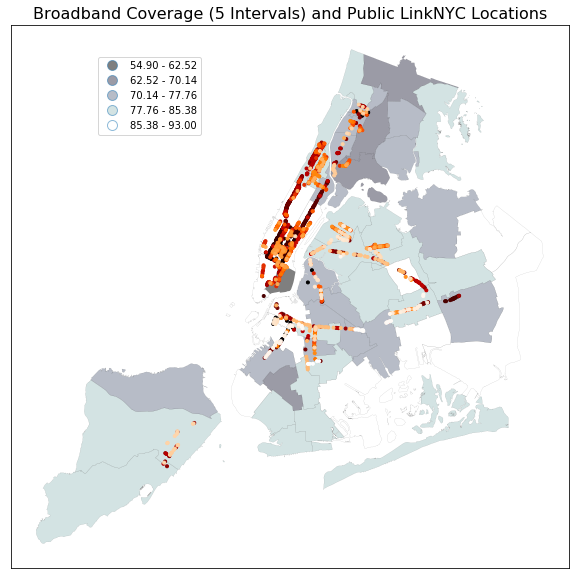

In [248]:
# Plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

f, ax = plt.subplots(figsize = (10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = puma_df.plot(column = 'HC01', cmap = 'bone', alpha = 0.5, edgecolor = 'black', linewidth = 0.1,
                 ax = ax, scheme = 'Equal_interval', legend = True, k = 5)
geoLinkNYC.plot(ax = ax, marker = '.', c = geoLinkNYC.date_link_, cmap = 'gist_heat')
plt.legend(loc = 2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.title("Broadband Coverage (5 Intervals) and Public LinkNYC Locations", size = 16)
plt.show()

### Figure 3
This is a map of boardband internet access across all PUMA areas and LinkNYC locations (free public wifi). Darker area has lower household boardband panetration (%). Each dot is a LinkNYC station and colored by the date of establishment. Darker color represent older stations.

Based on visual analysis, linkNYC stations have uneven coverage of areas with lower broadband access. Although there are many LinkNYC stations near South East of lower Manhattan, only major avenues in Bronx, middle of Queens, south Brooklyn have coverage.

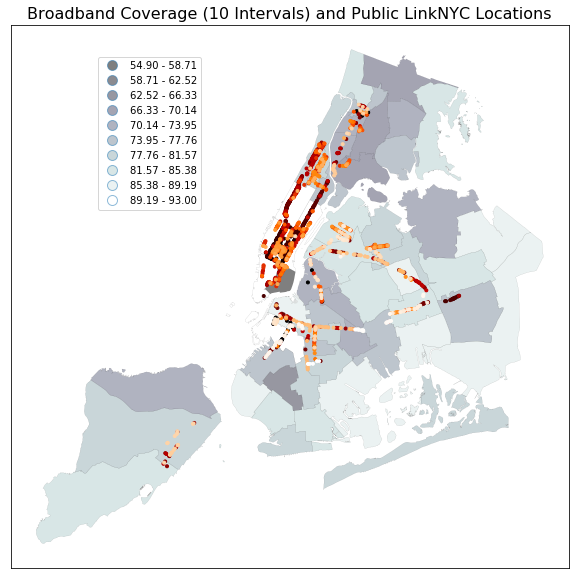

In [236]:
f, ax = plt.subplots(figsize = (10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = puma_df.plot(column = 'HC01', cmap = 'bone', alpha = 0.5, edgecolor = 'black', linewidth = 0.1,
                 ax = ax, scheme = 'Equal_interval', legend = True, k = 10)
geoLinkNYC.plot(ax = ax, marker = '.', c = geoLinkNYC.date_link_, cmap = 'gist_heat')
plt.legend(loc = 2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.title("Broadband Coverage (10 Intervals) and Public LinkNYC Locations", size = 16)
plt.show()

### Figure 4
This is a map of boardband internet access across all PUMA areas and LinkNYC locations (free public wifi). Darker area has lower household boardband panetration (%). Each dot is a LinkNYC station and colored by the date of establishment. Darker color represent older stations.

This map provides a more granular shading of broadband access using 10 equal interval bins.

---

## 5) Find the Number of LinkNYC Locations per Person by PUMA


In [196]:
# Get the Population per PUMA

keyNBB = 'B00001_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.columns = ['PUMA_Pop', "PUMA_Name", "State", "PUMA_id", "Unname"]

pumaPop.head()

,PUMA_Pop,PUMA_Name,State,PUMA_id,Unname
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [252]:
# Convert PUMA and LinkNYC Geometry to EPSG = 2263

geoLinkNYC_proj = geoLinkNYC.to_crs({'init':'epsg:2263'})
puma_df_proj = puma_df.to_crs({'init':'epsg:2263'})

In [259]:
# Merge PUMA and linkNYC datasets
linkpp = gpd.sjoin(puma_df_proj, geoLinkNYC_proj, how = "left").groupby("puma").size().reset_index(name = "linkCount")

In [260]:
# Calculate Number of linkNYC stations in each PUMA Area

linkpp = linkpp.sort_values(by='linkCount', ascending = False)
linkpp.head(10)

,puma,linkCount
16,3807,230
17,3808,164
15,3806,120
11,3802,81
14,3805,71
18,3809,62
12,3803,61
49,4109,51
41,4101,48
51,4111,40


In [200]:
# Merge with PUMA Population dataset
linkpp = linkpp.merge(pumaPop, how = "left", left_on = "puma", right_on = "PUMA_id")
linkpp = linkpp[['puma', 'linkCount', 'PUMA_Pop']]

In [201]:
# Calculate the Number of LinkNYC Station per 100 People by PUMA
linkpp['linkNYCp100p'] = linkpp['linkCount']*100 / linkpp['PUMA_Pop']
linkpp['linkNYCp100p'].describe()

count    55.000000
mean      1.580066
std       2.925439
min       0.024994
25%       0.050386
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

In [204]:
# Create a visual of LinkNYC Location and NUmber of LinkNYC Station per 100 people

puma_df = puma_df.merge(linkpp, how = "left", left_on = "puma", right_on = "puma")
puma_df.head()

,puma,shape_leng,shape_area,geometry,GEO.display-label,GCT_STUB.target-geo-id2,HC01,HC02,PUMA_id,linkCount,PUMA_Pop,linkNYCp100p
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,New York,3603701,84.3,2.6,3701,1,1517,0.065920
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,New York,3603702,68.3,3.7,3702,1,1959,0.051046
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,New York,3603703,82.8,3.2,3703,1,1305,0.076628
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",New York,3603704,72.6,3.6,3704,1,1882,0.053135
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,New York,3603705,69.4,3.2,3705,1,2011,0.049727


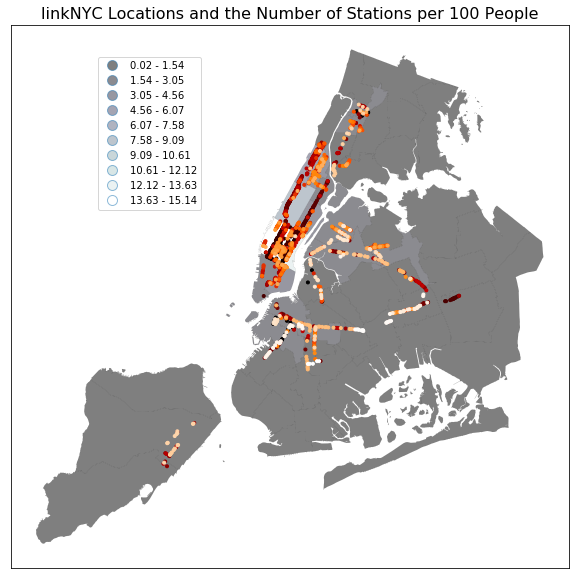

In [235]:
# plot linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

f, ax = plt.subplots(figsize = (10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = puma_df.plot(column = 'linkNYCp100p', cmap = 'bone', alpha = 0.5, edgecolor = 'black', linewidth = 0.1,
                 ax = ax, scheme = 'Equal_interval', legend = True, k = 10)
geoLinkNYC.plot(ax = ax, marker = '.', c = geoLinkNYC.date_link_, cmap = 'gist_heat')
plt.legend(loc = 2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.title("linkNYC Locations and the Number of Stations per 100 People", size = 16)
plt.show()

### Figure 5

This is a map of linkNYC station (colored by built date) and station per 100 people in each PUMA area. The legend, "13.63 - 15.14" for example, reads there are 13.63 to 15.14 linkNYC stations for every 100 people in this PUMA area. 

Not surprisingly, Manhattan area has more linkNYC stations per 100 people compare to the rest of the greater NYC area by 3-8 times approximately. This means one linkNYC station in Manhattan is shared by about 7 people. In contrast, a station, for example, in Bronx is shared by 65 people, who may also need to travel further to find a station given the area size and linkNYC station layout.

---

## Extra Credit 1

How to enhancing the visibility of the map due to small numbers? A solution is to pick a high contrast color legend like the following.

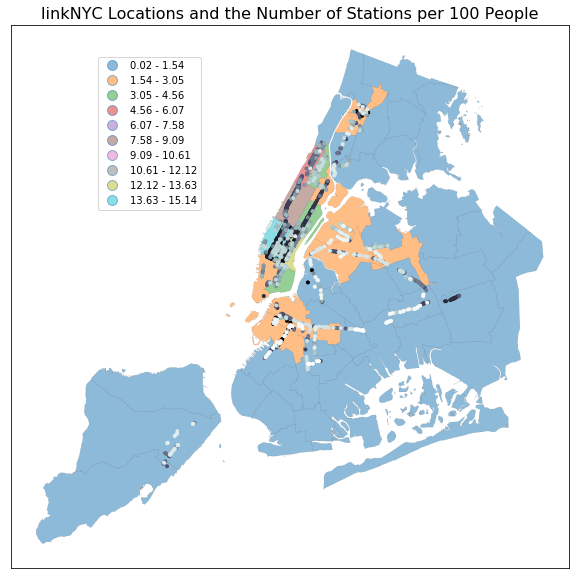

In [240]:
# plot linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

f, ax = plt.subplots(figsize = (10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = puma_df.plot(column = 'linkNYCp100p', cmap = 'tab10', alpha = 0.5, edgecolor = 'black', linewidth = 0.1,
                 ax = ax, scheme = 'Equal_interval', legend = True, k = 10)
geoLinkNYC.plot(ax = ax, marker = '.', c = geoLinkNYC.date_link_, cmap = 'bone')
plt.legend(loc = 2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.title("linkNYC Locations and the Number of Stations per 100 People", size = 16)
plt.show()

### Figure 6

This is a map of linkNYC station (colored by built date) and station per 100 people in each PUMA area. The legend, "13.63 - 15.14" for example, reads there are 13.63 to 15.14 linkNYC stations for every 100 people in this PUMA area.

This is an alternative to Figure 5 with high contrast color legend to emphasis on the difference in number of LinkNYC stations per 100 people across PUMA areas.